<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/0813/%ED%8A%B9%EC%84%B1_feature_%ED%99%95%EC%9D%B8_%EC%8B%A4%ED%97%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 드라이브 파일 train : https://drive.google.com/file/d/1F6Otr01l-sUUR_1AdTM925tAGDE_L--t/view?usp=drive_link
# test : https://drive.google.com/file/d/13lNIGs3wsD0mZF4OauV4GhZQHniNjK6d/view?usp=drive_link
# sub misson : https://drive.google.com/file/d/1RLdtGa4N62Q_5XFp0OOGTR5iVFObxjme/view?usp=drive_link

In [ ]:
!gdown https://drive.google.com/uc?id=1F6Otr01l-sUUR_1AdTM925tAGDE_L--t

In [ ]:
!gdown https://drive.google.com/uc?id=13lNIGs3wsD0mZF4OauV4GhZQHniNjK6d

In [ ]:
!pip install catboost

In [ ]:
!pip install optuna

In [ ]:
!pip install -U mlflow optuna

In [7]:
import os, math
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import missingno as msno

# scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error

# 분류 모델
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostRegressor

import warnings

# Auto ML
import optuna

warnings.filterwarnings('ignore')

In [143]:
train_data = pd.read_csv("/content/train.csv")
test_data = pd.read_csv("/content/test.csv")

In [144]:
df = train_data.copy()

### 필요없는 열 삭제

In [145]:
del df['FLAG_MOBIL']

### 모든 열 더해보자

In [146]:
# NAN값 Unknown으로 변경
df['occyp_type'] = df['occyp_type'].fillna("Unknown")

In [ ]:
# # 모든 열을 더해보자
# all_columns = df.columns[df.columns != 'begin_month']

# df['ID'] = df[all_columns].astype(str).apply(lambda x: '_'.join(x), axis=1) >> 70.8 (RF)

In [134]:
# # 모든 object 열을 더해보자
# object_columns = df.select_dtypes(include='object').columns
# df['ID'] = df[object_columns].astype(str).apply(lambda x: '_'.join(x), axis=1) >> 71.7 (RF)

In [202]:
# add_columns = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type',
#        'house_type', 'occyp_type', 'work_phone', 'email']
# df['ID'] = df[add_columns].astype(str).apply(lambda x: '_'.join(x), axis=1) >> 71.7 (RF)

In [228]:
# add_columns = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type',
#        'house_type', 'occyp_type', 'work_phone', 'email', 'DAYS_BIRTH']
# df['ID'] = df[add_columns].astype(str).apply(lambda x: '_'.join(x), axis=1) >> 71.7 (RF)

In [147]:
add_columns = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type',
       'house_type', 'occyp_type', 'work_phone', 'email', 'DAYS_BIRTH']
df['ID'] = df[add_columns].astype(str).apply(lambda x: '_'.join(x), axis=1)

In [148]:
# object열 확인
object_columns = df.select_dtypes(include='object').columns
object_columns

Index(['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type',
       'house_type', 'occyp_type', 'ID'],
      dtype='object')

### object열 인코딩

In [149]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
df[object_columns] = ordinal_encoder.fit_transform(df[object_columns], df['credit'])

In [150]:
df['ID'] = df['ID'].astype(int)

#### 추가

In [151]:
# 일한 일수 양수는 일하지 않았다고 보고 0.0000000001으로 변경
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: 0.0000000001 if x > 0 else x)

In [152]:
# 음수값 양수값으로 변경

features = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
for f in features:
    df[f] = df[f].abs()

In [153]:
# 안쓰면 71.3 ↓ 0.4
# 연으로 변경
df["YEAR_BIRTH"] = df["DAYS_BIRTH"] / 365
df['YEAR_EMPLOYED'] = df['DAYS_EMPLOYED'] / 365

# 달로 변경
df["MONTH_BIRTH"] = df["DAYS_BIRTH"] / 12
df['MONTH_EMPLOYED'] = df['DAYS_EMPLOYED'] / 12

# 주로 변경
df["WEEK_BIRTH"] = df["DAYS_BIRTH"] / 12
df['WEEK_EMPLOYED'] = df['DAYS_EMPLOYED'] / 12

# 일 안한 날 생성
df["No_work"] = df["DAYS_BIRTH"] - df['DAYS_EMPLOYED']


In [154]:
# 전화 하나로 변경
df['phones'] = df.loc[:, 'work_phone':'phone'].sum(axis = 1)
df = df.drop(['work_phone', 'phone'], axis=1)

In [155]:
# 가족 수에 아이들 수 추가
df['famliy_num'] = df.loc[:, 'child_num':'family_size'].sum(axis = 1)

In [156]:
# 연소득
df['income_year'] = df['income_total'] / 365
# 일한 일수로 소득 확인
# df['income'] =  df.apply(lambda row: row["income_total"] / row["DAYS_EMPLOYED"] if row["DAYS_EMPLOYED"] > 0 else 0, axis=1)

# 가족 수로 수입 나눔
df['income_mean'] = df['income_total'] / df['famliy_num']

# # 아이들 수로 수입 나눔
# df["income_child"] = df.apply(lambda row: row["income_total"] / row["child_num"] if row["child_num"] > 0 else row["income_total"], axis=1)
# df["income_child"] = df['income_total'] / df['child_num']+0.0000000001

# # 일한 날로 소득 생성
# df['income_work'] = df['income_total'] / df['DAYS_EMPLOYED']+0.0000000001

# # 나이(?) + 일한 날로 소득 생성(RF 71.6 ↓0.1)
# df['income_age'] = df['income_total'] / (df["DAYS_BIRTH"]+df['DAYS_EMPLOYED'])+0.0000000001

# 다 나눴으면 삭제
df = df.drop(['DAYS_EMPLOYED', 'income_total', 'DAYS_BIRTH','child_num', 'family_size'], axis=1)
# df.drop(columns=df['income_total'], inplace=True)

In [157]:
# 연관없는 것을 합쳐보자
# car+email (RF 71.8  ↑ 0.1)
df['car_email'] = df.loc[:, 'car':'email'].sum(axis = 1)
df = df.drop(['car', 'email'], axis=1)

# # gender + reality(RF 71.6 ↓0.1)
# df['gender_reality'] = df.loc[:, 'gender':'reality'].sum(axis = 1)
# df = df.drop(['gender', 'reality'], axis=1)

# gender + edu_type(RF 71.6 ↓0.1)
# df['gender_edu_type'] = df.loc[:, 'gender':'edu_type'].sum(axis = 1)
# df = df.drop(['gender', 'edu_type'], axis=1)

# income_type + edu_type(RF 71.6 ↓0.1)
# df['income_type_edu_type'] = df.loc[:, 'income_type':'edu_type'].sum(axis = 1)
# df = df.drop(['income_type', 'edu_type'], axis=1)

# # house_type + edu_type(RF 71.7)
# # df['house_type_edu_type'] = df.loc[:, 'house_type':'edu_type'].sum(axis = 1)
# df['house_type_edu_type'] = df['house_type']+df['edu_type']
# df = df.drop(['house_type', 'edu_type'], axis=1)

In [293]:
# float열 확인
float_columns = df.select_dtypes(include='float64').columns
float_columns

Index(['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type',
       'house_type', 'occyp_type', 'begin_month', 'credit', 'YEAR_BIRTH',
       'YEAR_EMPLOYED', 'MONTH_BIRTH', 'MONTH_EMPLOYED', 'WEEK_BIRTH',
       'WEEK_EMPLOYED', 'No_work', 'famliy_num', 'income_year', 'income_mean',
       'income_work', 'income_age'],
      dtype='object')

In [142]:
df

,index,gender,reality,income_type,edu_type,family_type,house_type,occyp_type,begin_month,credit,ID,No_work,phones,famliy_num,income_year,income_mean,car_email
0,0,0.0,0.0,0.0,1.0,1.0,2.0,17.0,6.0,1.0,56,9190.0,0,221131.0,554.794521,0.915747,4.0
1,1,0.0,1.0,0.0,4.0,0.0,1.0,8.0,5.0,1.0,1584,9840.0,0,260438.0,678.082192,0.950322,7.0
2,2,1.0,1.0,4.0,1.0,1.0,1.0,10.0,22.0,2.0,8101,14653.0,1,473540.0,1232.876712,0.950289,9.0
3,3,0.0,1.0,0.0,4.0,1.0,1.0,14.0,37.0,0.0,1768,12996.0,1,219702.0,554.794521,0.921703,7.0
4,4,0.0,1.0,2.0,1.0,1.0,1.0,10.0,26.0,2.0,5164,12932.0,0,174659.0,431.506849,0.901757,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,0.0,0.0,2.0,4.0,1.0,1.0,3.0,2.0,1.0,599,10095.0,0,239080.0,616.438356,0.941108,8.0
26453,26453,0.0,1.0,4.0,1.0,2.0,1.0,17.0,47.0,2.0,3222,12816.0,0,197794.0,493.150685,0.910038,9.0
26454,26454,0.0,0.0,4.0,4.0,0.0,5.0,3.0,25.0,2.0,4608,8067.0,0,304615.0,801.369863,0.960228,14.0
26455,26455,1.0,1.0,4.0,2.0,3.0,1.0,8.0,59.0,2.0,6545,10038.0,0,181271.0,468.493151,0.943339,11.0


In [253]:
for i in float_columns:
    df[i] = df[i].astype(int)

In [255]:
int_columns = df.select_dtypes(include='int').columns
int_columns

Index(['index', 'gender', 'car', 'reality', 'income_type', 'edu_type',
       'family_type', 'house_type', 'email', 'occyp_type', 'begin_month',
       'credit', 'ID', 'YEAR_BIRTH', 'YEAR_EMPLOYED', 'MONTH_BIRTH',
       'MONTH_EMPLOYED', 'WEEK_BIRTH', 'WEEK_EMPLOYED', 'No_work', 'phones',
       'famliy_num', 'income_year', 'income_mean', 'income_work'],
      dtype='object')

#### catboost 실험

In [260]:
!gdown 1RLdtGa4N62Q_5XFp0OOGTR5iVFObxjme

Downloading...
From: https://drive.google.com/uc?id=1RLdtGa4N62Q_5XFp0OOGTR5iVFObxjme
To: /content/sample_submission.csv
100% 120k/120k [00:00<00:00, 99.3MB/s]


In [261]:
test = pd.read_csv("/content/sample_submission.csv")

In [264]:
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import log_loss

n_est = 2000
seed = 42
n_fold = 30
n_class = 3

X = df.drop('credit', axis = 1)
y = df['credit']
X_test = test

In [265]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)

  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')



----------------- Fold 0 -----------------

Learning rate set to 0.115208
0:	learn: 1.0338151	test: 1.0319414	best: 1.0319414 (0)	total: 173ms	remaining: 2m 52s
100:	learn: 0.7034774	test: 0.6533738	best: 0.6533738 (100)	total: 11s	remaining: 1m 37s
200:	learn: 0.6862332	test: 0.6505682	best: 0.6503129 (168)	total: 21s	remaining: 1m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6503129254
bestIteration = 168

Shrink model to first 169 iterations.


CatBoostError: ignored

In [239]:
df

,index,gender,car,reality,income_type,edu_type,family_type,house_type,email,occyp_type,...,MONTH_BIRTH,MONTH_EMPLOYED,WEEK_BIRTH,WEEK_EMPLOYED,No_work,phones,famliy_num,income_year,income_mean,income_work
0,0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0,17.0,...,1158.250000,392.416667,1158.250000,392.416667,9190.0,0,221131.0,554.794521,0.915747,43.002761
1,1,0.0,0.0,1.0,0.0,4.0,0.0,1.0,1,8.0,...,948.333333,128.333333,948.333333,128.333333,9840.0,0,260438.0,678.082192,0.950322,160.714286
2,2,1.0,1.0,1.0,4.0,1.0,1.0,1.0,0,10.0,...,1590.583333,369.500000,1590.583333,369.500000,14653.0,1,473540.0,1232.876712,0.950289,101.488498
3,3,0.0,0.0,1.0,0.0,4.0,1.0,1.0,0,14.0,...,1257.333333,174.333333,1257.333333,174.333333,12996.0,1,219702.0,554.794521,0.921703,96.797323
4,4,0.0,1.0,1.0,2.0,1.0,1.0,1.0,0,10.0,...,1253.083333,175.416667,1253.083333,175.416667,12932.0,0,174659.0,431.506849,0.901757,74.821853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,0.0,0.0,0.0,2.0,4.0,1.0,1.0,0,3.0,...,1006.583333,165.333333,1006.583333,165.333333,10095.0,0,239080.0,616.438356,0.941108,113.407258
26453,26453,0.0,0.0,1.0,4.0,1.0,2.0,1.0,0,17.0,...,1274.250000,206.250000,1274.250000,206.250000,12816.0,0,197794.0,493.150685,0.910038,72.727273
26454,26454,0.0,1.0,0.0,4.0,4.0,0.0,5.0,0,3.0,...,840.166667,167.916667,840.166667,167.916667,8067.0,0,304615.0,801.369863,0.960228,145.161290
26455,26455,1.0,0.0,1.0,4.0,2.0,3.0,1.0,0,8.0,...,845.416667,8.916667,845.416667,8.916667,10038.0,0,181271.0,468.493151,0.943339,1598.130841


## 모델 불러오기

In [49]:
# 분류 모델
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostRegressor



# 커스텀 정보
models = {
    'LR' : LogisticRegression(penalty='l2', solver='saga', multi_class='multinomial', max_iter=300, n_jobs=4),
    'SVC' : SVC(kernel='rbf', max_iter=-1, random_state=777),
    'KNC' : KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree', n_jobs=4),
    'RFC' : RandomForestClassifier(n_estimators=300, random_state=777, n_jobs=4),
    # 'CAT' : CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, l2_leaf_reg=3, subsample=0.8, colsample_bylevel=0.8, random_seed=42, early_stopping_rounds=10,verbose=False),
    'GBC' : GradientBoostingClassifier(n_estimators=300, loss='log_loss', learning_rate=0.1, random_state=777, n_iter_no_change=5),
    'LGBM' : LGBMClassifier(n_estimators=300, boosting_type='gbdt', learning_rate=0.1, objective='multiclass', random_state=777, n_jobs=4),
    'XGB' : XGBClassifier(verbosity=0, num_parrell_tree=3),
}

In [50]:
def preprocessing(df, scale_cols, ohe, drops=['index', 'FLAG_MOBIL'], lbe=[], orde=[], scaler='std', test_size=0.2, fold=True, K=5):

    """__목표 기능__

    - 불필요 feature 제거
    - train_test_split
    - 표준화(Scaler, Encoder)


        __parameter 설명__

    - df: (필요 시) feature engineering을 마친 후의 df
    - drops: drop할 columns 리스트
    - scaler: 수치형(numerical) feature에 적용할 scaler('std'(StandardScaler), 'mm'(MinMaxScaler), 'robust'(RobustScaler) 중 택1)
    - scale_cols: Scale할 feature 리스트
    - ohe: OneHotEncoder를 적용할 feature 리스트
    - lbe: LabelEncoder를 적용할 feature 리스트
    - orde: OrdinalEncoder를 적용할 feature 리스트
    - test_size: train_test_split의 test_size
    - fold: K-Fold 적용 여부
    - K: K-Fold의 n_split
    """

    df = df.drop(columns=drops)

    X_data = df.drop(columns=['credit'])
    y_data = df['credit']

    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data,
                                                    test_size=test_size,
                                                    shuffle=True,
                                                    stratify=y_data,
                                                    random_state=777)

    if scaler == 'std':
        scale = StandardScaler()
    elif scaler == 'mm':
        scale = MinMaxScaler()
    elif scaler == 'robust':
        scale = RobustScaler()

    mct = make_column_transformer(
            (scale, scale_cols),
            (OneHotEncoder(), ohe),
            (LabelEncoder(), lbe),
            (OrdinalEncoder(), orde)
            )


    mct = mct.fit(X_train)
    if fold:
        X_train_scaled = mct.transform(X_data)
        return X_train_scaled, y_data

    else:
        X_train_scaled = mct.transform(X_train)
        X_val_scaled = mct.transform(X_val)
        return X_train_scaled, X_val_scaled, y_train, y_val


def baseline(X_train, y_train, fold=True, print_msg='Trial'):

    """__목표 기능__

    - 하이퍼파라미터 튜닝 없이 단순히 여러 모델의 성능을 확인하여 전반적으로 feature handling이 잘 되었는지 검증

        __parameter 설명__

    - X_train: preprocessing()의 output
    - y_train: preprocessing()의 output
    - fold: 학습 및 성능 확인 간 K-Fold(교차검증) 적용 여부
    - print_msg: 학습 시작할 때 출력할 메시지

    """

    result_list, result_name = [], []

    if fold:
        kfold = KFold(n_splits=5, shuffle=True, random_state=1)

        print('(K_Fold 적용) ' + print_msg)
        for name, model in tqdm(models.items()):
            r1 = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold)
            print(f'{name} 평균 성능 수치 : {r1.mean()}')

            result_list.append(r1.mean())
            result_name.append(f'{models[name]} Basic')

        result = {k:v for k, v in zip(result_name, result_list)}

    else:
        print('(K_Fold 미적용) ' + print_msg)
        for name, model in tqdm(models.items()):
            r1 = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold)
            print(f'{name} 평균 성능 수치 : {r1.mean()}')

            result_list.append(r1.mean())
            result_name.append(f'{models[name]} Basic')
        print()
        result = {k:v for k, v in zip(result_name, result_list)}

    return result


In [158]:
# 훈련데이터 분할
target = df['credit']
train = df.drop('credit', axis = 1)

#### 모델 검증

In [159]:
none = baseline(train,target)
none

(K_Fold 적용) Trial


  0%|          | 0/7 [00:00<?, ?it/s]

LR 평균 성능 수치 : 0.6413426984855557
SVC 평균 성능 수치 : 0.6413426984855557
KNC 평균 성능 수치 : 0.5527461456032884
RFC 평균 성능 수치 : 0.7176929462643749
GBC 평균 성능 수치 : 0.693578429292715
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3107
[LightGBM] [Info] Number of data points in the train set: 21165, number of used features: 22
[LightGBM] [Info] Start training from score -2.104559
[LightGBM] [Info] Start training from score -1.442511
[LightGBM] [Info] Start training from score -0.443530
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3106
[LightGBM] [Info] Number of data points in the trai

{"LogisticRegression(max_iter=300, multi_class='multinomial', n_jobs=4,\n                   solver='saga') Basic": 0.6413426984855557,
 'SVC(random_state=777) Basic': 0.6413426984855557,
 "KNeighborsClassifier(algorithm='kd_tree', n_jobs=4) Basic": 0.5527461456032884,
 'RandomForestClassifier(n_estimators=300, n_jobs=4, random_state=777) Basic': 0.7176929462643749,
 'GradientBoostingClassifier(n_estimators=300, n_iter_no_change=5,\n                           random_state=777) Basic': 0.693578429292715,
 "LGBMClassifier(n_estimators=300, n_jobs=4, objective='multiclass',\n               random_state=777) Basic": 0.7094909809195523,
 'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n          

#### 가장 높은 랜덤 포레스트로 어떤 특성을 많이 봤는지 확인

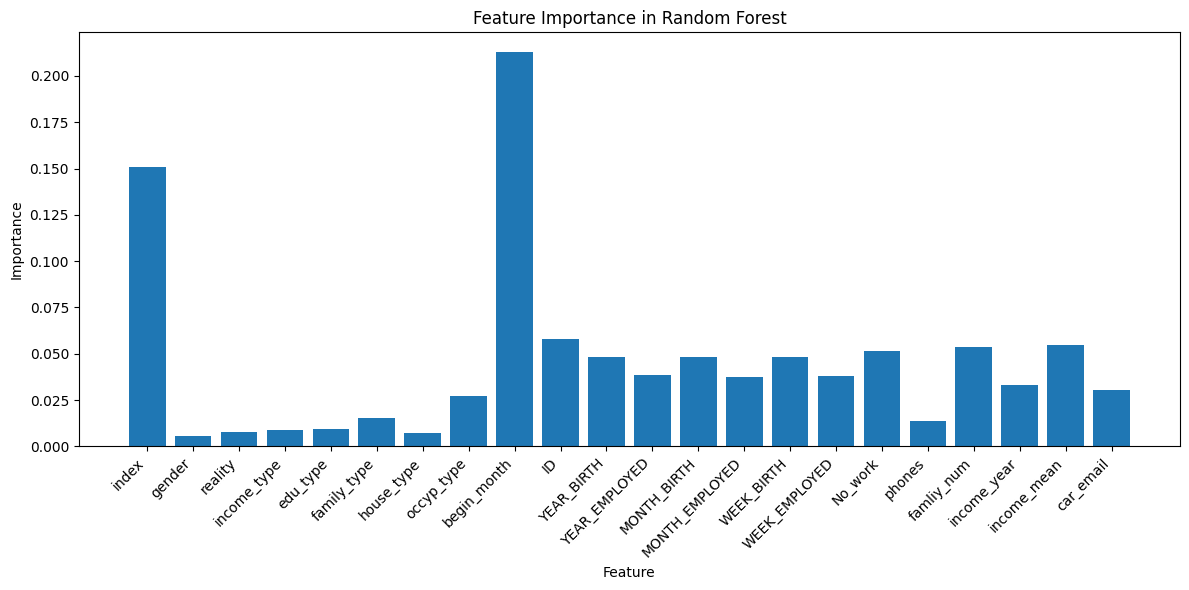

In [160]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# # 데이터셋을 불러오거나 예시 데이터셋을 생성합니다
# # 'data'라는 DataFrame이 특성과 타겟 열을 포함하고 있다고 가정합니다
# # features = data.drop('target', axis=1)
# # target = data['target']

# # 데이터를 훈련 및 테스트 세트로 분할합니다
X_train, X_val, y_train, y_val = train_test_split(train, target,
                                                test_size=0.2,
                                                shuffle=True,
                                                stratify=target,
                                                random_state=777)

# 랜덤 포레스트 분류 모델을 생성합니다
rf_classifier = RandomForestClassifier(n_estimators=300, random_state=777, n_jobs=4)

# 모델을 훈련합니다
rf_classifier.fit(X_train, y_train)

# 특성 중요도를 얻습니다
rf_importances = rf_classifier.feature_importances_
rf_feature_names = train.columns

# 특성 중요도 그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(rf_feature_names, rf_importances)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.tight_layout()
plt.show()

In [316]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

# Assuming you have already created and trained the CatBoostRegressor model
model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, l2_leaf_reg=3, subsample=0.8, colsample_bylevel=0.8, random_seed=42, early_stopping_rounds=10,verbose=False)

# Calculate the cross-validated MAE
kfold = 5  # Number of cross-validation folds
mae_scores = cross_val_score(model, train,target, scoring='neg_mean_absolute_error', cv=kfold)

# Convert the negative MAE scores to positive
mae_scores = -mae_scores

# Print the mean MAE and its standard deviation
print("Mean MAE:", mae_scores.mean())
print("MAE Standard Deviation:", mae_scores.std())

Mean MAE: 0.5575818642726957
MAE Standard Deviation: 0.0034402553166439534


##### ID + 음수를 양수로 변경

In [ ]:
base = baseline(train,target)
base

(K_Fold 적용) Trial


  0%|          | 0/8 [00:00<?, ?it/s]

LR 평균 성능 수치 : 0.6413426984855557
SVC 평균 성능 수치 : 0.6413426984855557
KNC 평균 성능 수치 : 0.5415961058818202
RFC 평균 성능 수치 : 0.7058247486818914
CAT 평균 성능 수치 : nan
GBC 평균 성능 수치 : 0.691877391877392
LGBM 평균 성능 수치 : 0.7013644085072658
XGB 평균 성능 수치 : 0.698189469618041


{"LogisticRegression(max_iter=300, multi_class='multinomial', n_jobs=4,\n                   solver='saga') Basic": 0.6413426984855557,
 'SVC(random_state=777) Basic': 0.6413426984855557,
 "KNeighborsClassifier(algorithm='kd_tree', n_jobs=4) Basic": 0.5415961058818202,
 'RandomForestClassifier(n_estimators=300, n_jobs=4, random_state=777) Basic': 0.7058247486818914,
 '<catboost.core.CatBoostRegressor object at 0x7eab81791f00> Basic': nan,
 'GradientBoostingClassifier(n_estimators=300, n_iter_no_change=5,\n                           random_state=777) Basic': 0.691877391877392,
 "LGBMClassifier(n_estimators=300, n_jobs=4, objective='multiclass',\n               random_state=777) Basic": 0.7013644085072658,
 'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              ga

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

# Assuming you have already created and trained the CatBoostRegressor model
model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, l2_leaf_reg=3, subsample=0.8, colsample_bylevel=0.8, random_seed=42, early_stopping_rounds=10,verbose=False)

# Calculate the cross-validated MAE
kfold = 5  # Number of cross-validation folds
mae_scores = cross_val_score(model, train,target, scoring='neg_mean_absolute_error', cv=kfold)

# Convert the negative MAE scores to positive
mae_scores = -mae_scores

# Print the mean MAE and its standard deviation
print("Mean MAE:", mae_scores.mean())
print("MAE Standard Deviation:", mae_scores.std())

Mean MAE: 0.559512738418365
MAE Standard Deviation: 0.005577935758075336


##### ID + 양수화 + 소득 분할

In [ ]:
inf_count = (df == float('inf')).sum()
inf_count

index            0
gender           0
car              0
reality          0
child_num        0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
ID               0
income_year      0
income           0
income_mean      0
dtype: int64

In [ ]:
base = baseline(train,target)
base

(K_Fold 적용) Trial


  0%|          | 0/7 [00:00<?, ?it/s]

LR 평균 성능 수치 : 0.6413426984855557
SVC 평균 성능 수치 : 0.6413426984855557
KNC 평균 성능 수치 : 0.5331294759866188
RFC 평균 성능 수치 : 0.7077145862860148
GBC 평균 성능 수치 : 0.6912349198063483
LGBM 평균 성능 수치 : 0.7020449949021377
XGB 평균 성능 수치 : 0.6993233921805351


{"LogisticRegression(max_iter=300, multi_class='multinomial', n_jobs=4,\n                   solver='saga') Basic": 0.6413426984855557,
 'SVC(random_state=777) Basic': 0.6413426984855557,
 "KNeighborsClassifier(algorithm='kd_tree', n_jobs=4) Basic": 0.5331294759866188,
 'RandomForestClassifier(n_estimators=300, n_jobs=4, random_state=777) Basic': 0.7077145862860148,
 'GradientBoostingClassifier(n_estimators=300, n_iter_no_change=5,\n                           random_state=777) Basic': 0.6912349198063483,
 "LGBMClassifier(n_estimators=300, n_jobs=4, objective='multiclass',\n               random_state=777) Basic": 0.7020449949021377,
 'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n         

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

# Assuming you have already created and trained the CatBoostRegressor model
model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, l2_leaf_reg=3, subsample=0.8, colsample_bylevel=0.8, random_seed=42, early_stopping_rounds=10,verbose=False)

# Calculate the cross-validated MAE
kfold = 5  # Number of cross-validation folds
mae_scores = cross_val_score(model, train,target, scoring='neg_mean_absolute_error', cv=kfold)

# Convert the negative MAE scores to positive
mae_scores = -mae_scores

# Print the mean MAE and its standard deviation
print("Mean MAE:", mae_scores.mean())
print("MAE Standard Deviation:", mae_scores.std())

Mean MAE: 0.558141517988878
MAE Standard Deviation: 0.005735500055772106


### Using Optuna with LightGBM (Auto ML 활용 실험)
- objective 함수를 생성한 다음, 다양한 parameter 값을 적용
- optuna.create_study 객체로 지정된 study가 가장 최적화된 best_params를 가짐

<출처> https://blog.naver.com/qkrdnjsrl0628/222797273335

In [ ]:
# LightGBM

def LGBM(trial,data=train,target=target):

    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    param = {
        'metric': 'rmse',
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = lgb.LGBMRegressor(**param)

    model.fit(train_x,train_y,eval_set=[(test_x,test_y)], early_stopping_rounds= 100)

    preds = model.predict(test_x)

    rmse = mean_squared_error(test_y, preds,squared=False)

    return rmse

In [ ]:
# XGBM
def XGBM(trial,data=train,target=target):

    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)

    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)

    preds = model.predict(test_x)

    rmse = mean_squared_error(test_y, preds,squared=False)

    return rmse

In [ ]:
# Catboost

def Cat(trial,data=train,target=target):

    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)

    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)

    preds = model.predict(test_x)

    rmse = mean_squared_error(test_y, preds,squared=False)

    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(LGBM, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(XGBM, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(Cat, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
# rf_importances = rf_classifier.feature_importances_
# rf_feature_names = X.columns

# # 특성 중요도 그래프 그리기
# plt.figure(figsize=(12, 6))
# plt.bar(rf_feature_names, rf_importances)
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('Feature')
# plt.ylabel('Importance')
# plt.title('Feature Importance in Random Forest')
# plt.tight_layout()
# plt.show()

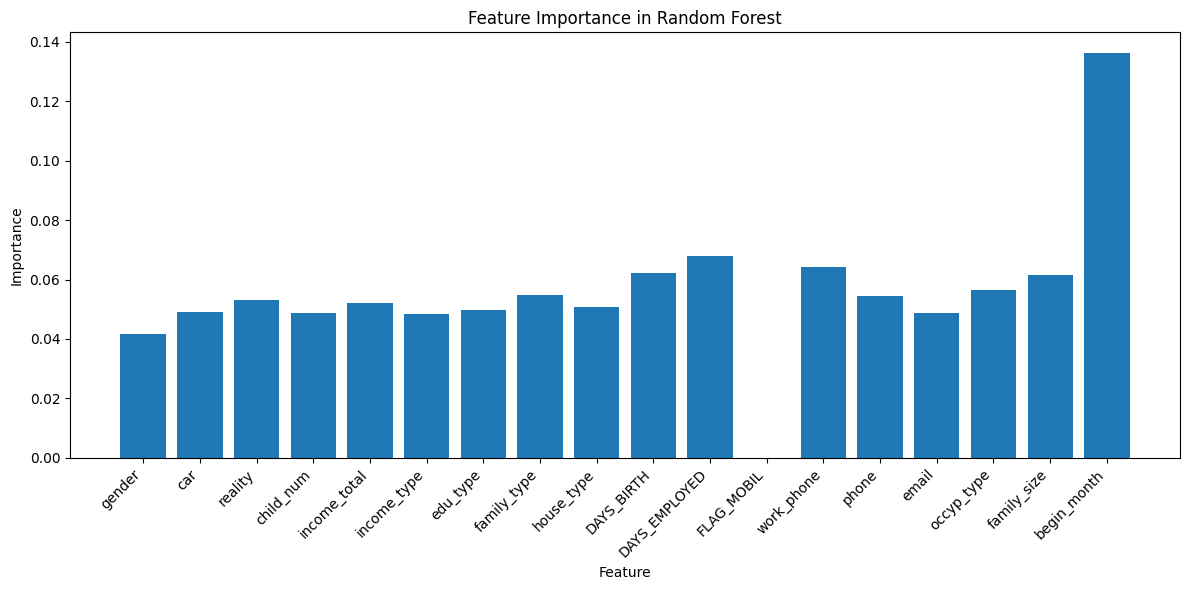

In [ ]:
# xgb_importances = xgb_classifier.feature_importances_
# xgb_feature_names = X.columns

# # 특성 중요도 그래프 그리기
# plt.figure(figsize=(12, 6))
# plt.bar(xgb_feature_names, xgb_importances)
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('Feature')
# plt.ylabel('Importance')
# plt.title('Feature Importance in Random Forest')
# plt.tight_layout()
# plt.show()

### AUTO ML
-<출처> https://velog.io/@otzslayer/MLflow%EC%99%80-Optuna-%EC%9D%B4%EC%9A%A9%ED%95%98%EC%97%AC-%EB%AA%A8%EB%8D%B8-%ED%8A%9C%EB%8B%9D%ED%95%98%EA%B3%A0-%EA%B4%80%EB%A6%AC%ED%95%98%EA%B8%B0

In [ ]:
from typing import List

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# def load_data() -> tuple[pd.DataFrame, np.ndarray]:
#     df = pd.read_csv("./data/train.csv")

#     y = np.log1p(df["SalePrice"].ravel())
#     X = df.drop(["Id", "Alley", "PoolQC", "Fence",
#                 "MiscFeature", "SalePrice"], axis=1)
# return X, y

def identify_column_types(X: pd.DataFrame): #-> tuple[List, List]
    num_cols = X.select_dtypes("number").columns.tolist()
    cat_cols = X.select_dtypes("object").columns.tolist()

    return num_cols, cat_cols

def make_preprocess_pipeline(num_cols, cat_cols): # -> ColumnTransformer
    num_processor = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler",  MinMaxScaler())
    ])

    cat_processor = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",
                                  fill_value="None"))
    ])

    preprocessor = ColumnTransformer([
        ("num", num_processor, num_cols),
        ("cat", cat_processor, cat_cols)
    ])

    return preprocessor

y = df['credit']
X = df.drop('credit', axis = 1)

num_cols, cat_cols = identify_column_types(X)

preprocessor = make_preprocess_pipeline(num_cols, cat_cols)

X_ = pd.DataFrame(preprocessor.fit_transform(X, y),
                  columns=num_cols+cat_cols)

In [ ]:
import catboost
import optuna

class Objective(object):
    def __init__(self, pool):
        self.pool = pool

    def __call__(self, trial):
        pool = self.pool

        max_depth = trial.suggest_int("max_depth", 3, 10)
        learning_rate = trial.suggest_float("learning_rate", 0.05, 0.3)
        subsample = trial.suggest_float("subsample", 0.75, 1)
        l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1e-5, 1e-1, log=True)

        params = {"loss_function": "RMSE",
                "depth": max_depth,
                "learning_rate": learning_rate,
                "subsample": subsample,
                "l2_leaf_reg": l2_leaf_reg}

        cv_result = catboost.cv(pool=pool,
                                params=params,
                                num_boost_round=1000,
                                nfold=5,
                                seed=0,
                                early_stfopping_rounds=30,
                                verbose=False)

        rmsle = cv_result["test-RMSE-mean"].min()

        return rmsle

pool = catboost.Pool(X_, label=y, cat_features=cat_cols)
objective = Objective(pool)

study = optuna.create_study(
    study_name="house_price_prediction",
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(max_resource="auto")
)

[I 2023-08-13 00:56:00,373] A new study created in memory with name: house_price_prediction


#### Web UI 확인
최적화 중, 또는 최적화 완료 후에 mlruns 폴더가 있는 경로에서 다음 명령어를 입력합니다.

 $ mlflow ui
그러면 로컬호스트에 5000번 포트를 통해서 UI 페이지로 접근할 수 있습니다.

 https://127.0.0.1:5000
tracking_uri가 있는 폴더에서 제대로 실행했다면 아래와 같은 UI 페이지를 확인할 수 있습니다.



In [ ]:
%cd

In [ ]:
! mlflow ui

In [ ]:
from optuna.integration.mlflow import MLflowCallback

def make_mlflow_callback():
    cb = MLflowCallback(
         tracking_uri="mlruns",
         metric_name="RMSLE"
    )
    return cb

mlflow_cb = make_mlflow_callback()
study.optimize(objective, n_trials=50, callbacks=[mlflow_cb])

## SCV irls 데이터로 ML

In [ ]:
import os
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import optuna
from optuna.integration.mlflow import MLflowCallback

# iris = load_iris()
# trainx, testx, trainy, testy = train_test_split(iris.data, iris.target, test_size=0.2)
trainx, testx, trainy, testy = train_test_split(train,target,test_size=0.2)

def objective(trial):
    gamma = trial.suggest_loguniform('gamma', 1e-3, 3.0)
    C = trial.suggest_loguniform('C', 1e+0, 1e+2/2)
    kernel = trial.suggest_categorical('kernel', ['linear','rbf','sigmoid'])
    svc = SVC(gamma=gamma, C=C, kernel=kernel)
    svc.fit(trainx, trainy)
    predy = svc.predict(testx)
    accuracy = accuracy_score(testy, predy)
    return accuracy

if __name__=='__main__':

    mlflc = MLflowCallback(tracking_uri='ml_exp',
                      metric_name='accuracy')
    study = optuna.create_study(study_name='iris_test')
    study.optimize(objective, n_trials=50, callbacks=[mlflc])

[I 2023-08-13 00:58:26,490] A new study created in memory with name: iris_test


In [ ]:
def objective(trial):
    gamma = trial.suggest_loguniform('gamma', 1e-3, 3.0)
    C = trial.suggest_loguniform('C', 1e+0, 1e+2/2)
    kernel = trial.suggest_categorical('kernel', ['linear','rbf','sigmoid'])
    svc = SVC(gamma=gamma, C=C, kernel=kernel)
    svc.fit(trainx, trainy)
    predy = svc.predict(testx)
    accuracy = accuracy_score(testy, predy)
    return accuracy

if __name__=='__main__':

    mlflc = MLflowCallback(tracking_uri='ml_exp',
                      metric_name='accuracy')
    study = optuna.create_study(study_name='iris_test')
    study.optimize(objective, n_trials=50, callbacks=[mlflc])

In [ ]:
! mlflow ui --backend-store-uri file:///home/user/dev/mlflowsample/test_optuna/ml_exp/

## 다른거

In [ ]:
# 참고 : https://teddylee777.github.io/machine-learning/auto-tuning-models/

In [ ]:
!pip install -U teddynote

In [ ]:
# 모듈 import
from teddynote import models

In [ ]:
# 샘플 데이터 load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.datasets import load_iris, load_boston, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

warnings.filterwarnings('ignore')

SEED = 2021